<a href="https://colab.research.google.com/github/ashaaher/Deep-Learning/blob/master/Ungraded-5/5_Overfit_and_underfit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.2.0-rc4


In [0]:
!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [0]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [0]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [0]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [0]:
FEATURES = 28

The tf.data.experimental.CsvDataset class can be used to read csv records directly from a gzip file with no intermediate decompression step.

In [0]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

That csv reader class returns a list of scalars for each record. The following function repacks that list of scalars into a (feature_vector, label) pair.

In [0]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

TensorFlow is most efficient when operating on large batches of data.

So instead of repacking each row individually make a new Dataset that takes batches of 10000-examples, applies the pack_row function to each batch, and then splits the batches back up into individual records:

In [0]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


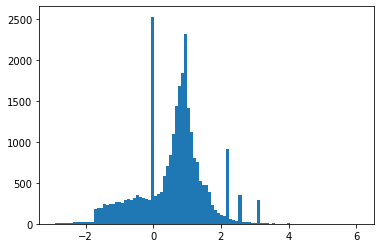

In [0]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

In [0]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [0]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [0]:
train_ds

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

In [0]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

**Demonstrate Overfitting**

Training procedure
Many models train better if you gradually reduce the learning rate during training. Use optimizers.schedules to reduce the learning rate over time:

In [0]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

The code above sets a schedules.InverseTimeDecay to hyperbolically decrease the learning rate to 1/2 of the base rate at 1000 epochs, 1/3 at 2000 epochs and so on.

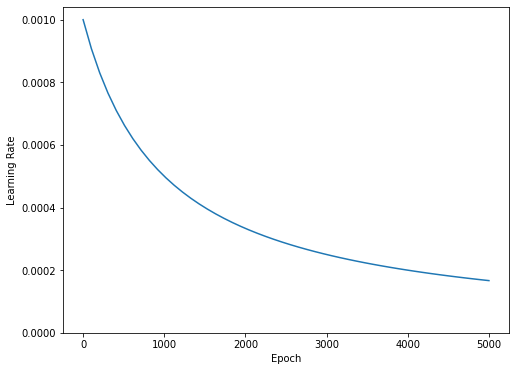

In [0]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

Each model in this tutorial will use the same training configuration. So set these up in a reusable way, starting with the list of callbacks.

The training for this tutorial runs for many short epochs. To reduce the logging noise use the tfdocs.EpochDots which simply prints a . for each epoch, and a full set of metrics every 100 epochs.

Next include callbacks.EarlyStopping to avoid long and unnecessary training times. Note that this callback is set to monitor the val_binary_crossentropy, not the val_loss. This difference will be important later.

Use callbacks.TensorBoard to generate TensorBoard logs for the training.

In [0]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

Similarly each model will use the same Model.compile and Model.fit settings:

In [0]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

Training Model

In [0]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [0]:
size_histories = {}

In [0]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 16)                464       
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4809,  binary_crossentropy:0.8175,  loss:0.8175,  val_accuracy:0.5060,  val_binary_crossentropy:0.7487,  val_loss:0.7487,  
....................................................................................................
Epoch: 100, accuracy:0.6069,  binary_crossentropy:0.6210,  loss:0.6210,  val_accuracy:0.6010,  val_binary_crossentropy:0.6223,  val_loss:0.6223,  
....................................................................................................
Epoch: 200, accuracy:0

(0.5, 0.7)

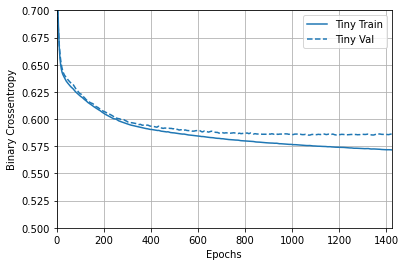

In [0]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

In [0]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [0]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 16)                464       
_________________________________________________________________
dense_36 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4845,  binary_crossentropy:0.7237,  loss:0.7237,  val_accuracy:0.4740,  val_binary_crossentropy:0.7061,  val_loss:0.7061,  
....................................................................................................
Epoch: 100, accuracy:0.6434,  binary_crossentropy:0.6045,  loss:0.6045,  val_accuracy:0.6310,  val_binary_crossentropy:0.6021,  val_loss:0

Medium Model

In [0]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

In [0]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 64)                1856      
_________________________________________________________________
dense_39 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_40 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4890,  binary_crossentropy:0.6922,  loss:0.6922,  val_accuracy:0.4780,  val_binary_crossentropy:0.6813,  val_loss:0.6813,  
....................................................................................................


Large Model

In [0]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

In [0]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_65 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_66 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_67 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_68 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5062,  binary_crossentropy:0.8134,  loss:0.8134,  val_accuracy:0.4810,  val_binary_crossent

Text(0.5, 0, 'Epochs [Log Scale]')

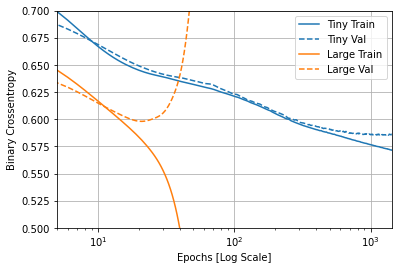

In [0]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

In [0]:
#%tensorboard --logdir {logdir}/sizes

#docs_infra: no_execute
%tensorboard --logdir {logdir}/sizes

UsageError: Line magic function `%tensorboard` not found.


In [0]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")

**Strategies to prevent overfitting**
Before getting into the content of this section copy the training logs from the "Tiny" model above, to use as a baseline for comparison

In [0]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/tmp/tmptvdooj3y/tensorboard_logs/regularizers/Tiny')

In [0]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

In [0]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_70 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_71 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_72 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_73 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5020,  binary_crossentropy:0.7890,  loss:2.3038,  val_accuracy:0.4750,  val_binary_crossent

(0.5, 0.7)

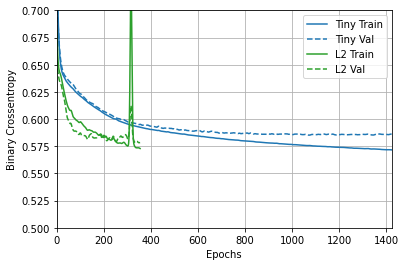

In [0]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [0]:
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)

In [0]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_76 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_77 (Dense)             (None, 512)             

(0.5, 0.7)

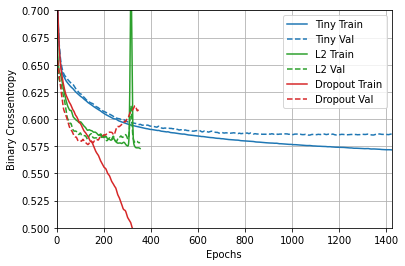

In [0]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

Combined L2 + Dropout

In [0]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_79 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_16 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_80 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_18 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 512)             

(0.5, 0.7)

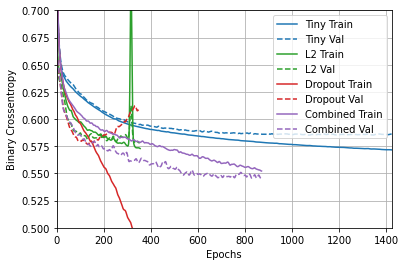

In [0]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

View in TensorBoard

In [0]:
display.IFrame(
    src="https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97",
    width = "100%",
    height="800px")

**Conclusions**

To recap: here are the most common ways to prevent overfitting in neural networks:

Get more training data.
Reduce the capacity of the network.
Add weight regularization.
Add dropout.
Two important approaches not covered in this guide are:


data-augmentation
batch normalization
Remember that each method can help on its own, but often combining them can be even more effective.

